In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import HBPASM.data.data as data
import os
import torch.backends.cudnn as cudnn
from PIL import Image
import HBPASM.model.HBPASM_model as HBPASM_model
from torchvision import datasets, ops
from HBPASM.utils.utils import progress_bar
import torchmetrics
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torchsummary import summary
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import LambdaLR
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Lambda
from focal_loss import FocalLoss
import torchvision
from albumentations.core.transforms_interface import DualTransform
import albumentations as A
from albumentations.pytorch import ToTensorV2
import differaugment as augment
from Ranger21.ranger21.ranger21 import Ranger21
import custom_utils as custom_utils
from WeightedKappaLoss import WeightedKappaLoss
import torchvision.transforms.functional as F
from sklearn.model_selection import KFold
from ordinalencodedmodel import ModelVer1,ModelVer1FocalLosswithSGD,ModelVer1FocalLossonly
import encodetestoptimizermodel as optimizermodel
import crossvalidationtestmodel as crossvalidatemodel
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def plot_multipledataset(df):
    metrics = set()
    num_metrics = 6  # Excluding "Train Confusion Matrix" and "Test Confusion Matrix"
    subplot_rows = 2
    subplot_cols = 3

    fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(10, 6))

    subplot_idx = 0 

    for i, column in enumerate(df.columns):
        if column != "Test Confusion Matrix" and column!='Dataset Name':
            row = subplot_idx // subplot_cols
            col = subplot_idx % subplot_cols
            ax = axs[row, col]
            ax.bar(df['Dataset Name'], df[column])
            ax.set_xlabel('Dataset Name')
            ax.set_ylabel(column)
            ax.set_title(f'Bar Graph for {column}')
            ax.tick_params(axis='x', rotation=45)
            ax.tick_params(axis='x', which='both', labelbottom=True)
            ax.tick_params(axis='y', which='both', labelleft=True)
            subplot_idx += 1

    plt.tight_layout()
    plt.show()

# 300 image circle crop

In [2]:
IMG_SIZE=300
# batch size for effv2 can be 512
batch_size=64
processedimagedir='ben processed circle crop'
image_dir = os.path.join('..', 'dataset',processedimagedir,'aptos2019')
aptos2019testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
aptos2019testloader = torch.utils.data.DataLoader(aptos2019testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'ddrtest')
ddrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
ddrtestloader = torch.utils.data.DataLoader(ddrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'fgadr')
fgadrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
fgadrtestloader = torch.utils.data.DataLoader(fgadrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'idridtest')
idridtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
idridtesttestloader = torch.utils.data.DataLoader(idridtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'retinallesion')
retinallesiontestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
retinallesiontestloader = torch.utils.data.DataLoader(retinallesiontestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'kaggletest')
kaggletesttestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
kaggletesttestloader = torch.utils.data.DataLoader(kaggletesttestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True


In [ ]:
#effv2 model
effv2path=[r".\Effv2m\Effv2m_ranger21_300circlecrop_augmix",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_fencemask",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_gridmask",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_normalaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_randaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_resample_normalaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_resample_randaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_trivialaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_normalaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_randaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_trivialaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_augmix",
 r".\Effv2m\Effv2m_ranger21_300clahe_gidmask",
 r".\Effv2m\Effv2m_ranger21_300clahe_fencemask",
 r".\Effv2m\Effv2m_ranger21_300defaultben_normalaug",
 r".\Effv2m\Effv2m_ranger21_300defaultben_randaug",
 r".\Effv2m\Effv2m_ranger21_300defaultben_trivialaug"]

#HBPASMwEffV2
[r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_augmix2",
 r".\HBPASMwithEffv2\HBPASMwEffv2_ranger21_300clahe_fencemask2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_gridmask2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_normalaug2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_randaug2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_trivialaug2",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_normalaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_randaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_trivialaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_normalaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_randaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_trivialaug"]

#HBPASMDSOD
[r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_normalaug2",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_resample_normalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_resample_randaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropaugmix",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropfencemask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropgridmask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropnormalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecroprandaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecroptrivialaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_augmix",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_fencemask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_gridmask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_normalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_randaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_trivialaug"]

# circle crop with EfficientNetV2_M

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 1s423ms | Tot: 14s765ms | te 8/8 

aptos2019Test set: Average loss: 0.0039, Accuracy: 985/3662 (26.90%), Cohen's Kappa: 0.0991, QWK Score: 0.6089, F1-Score: 0.1884, Specificity: 0.8305
----------------------------------------Test--------

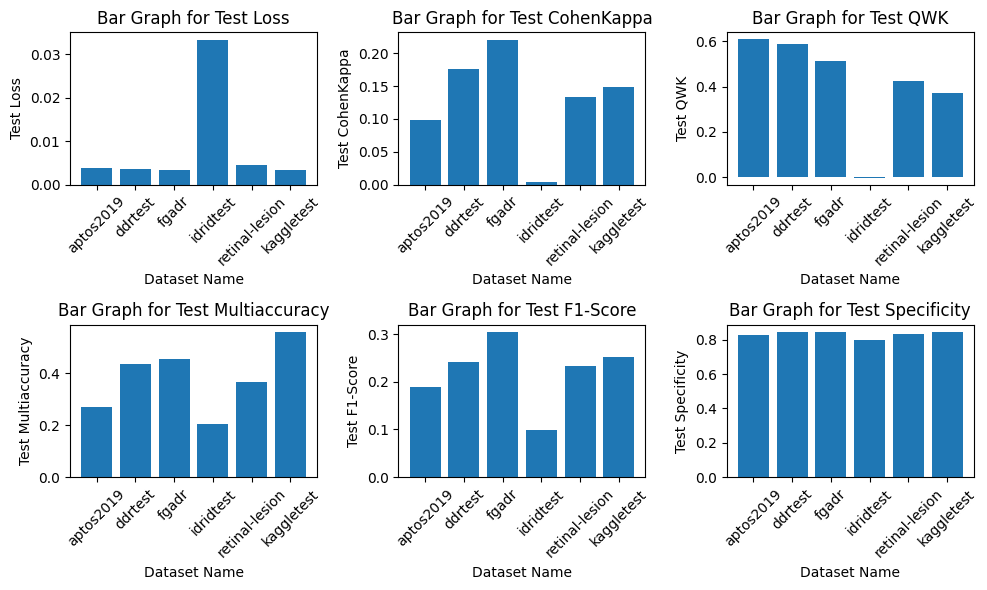

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 389ms | Tot: 13s734ms | tes 8/8  

aptos2019Test set: Average loss: 0.0044, Accuracy: 1852/3662 (50.57%), Cohen's Kappa: 0.1351, QWK Score: 0.3141, F1-Score: 0.2270, Specificity: 0.8270
----------------------------------------Test-------

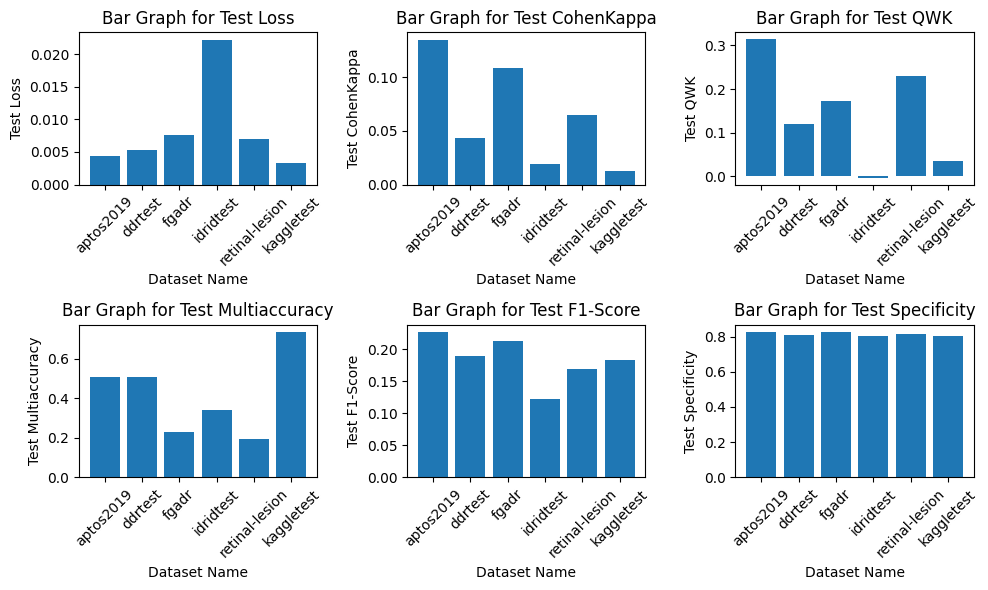

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 401ms | Tot: 13s728ms | tes 8/8  

aptos2019Test set: Average loss: 0.0037, Accuracy: 2097/3662 (57.26%), Cohen's Kappa: 0.3129, QWK Score: 0.4849, F1-Score: 0.3312, Specificity: 0.8662
----------------------------------------Test-------

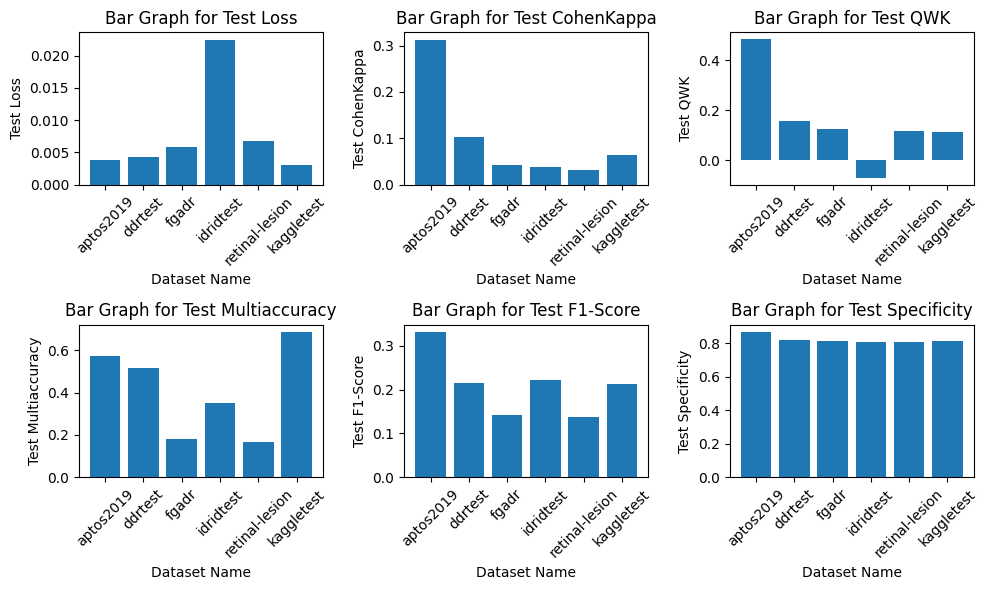

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 381ms | Tot: 19s81ms | test 8/8  

aptos2019Test set: Average loss: 0.0039, Accuracy: 1112/3662 (30.37%), Cohen's Kappa: 0.1462, QWK Score: 0.6182, F1-Score: 0.2784, Specificity: 0.8377
----------------------------------------Test-------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 372ms | Tot: 13s134ms | tes 8/8  

aptos2019Test set: Average loss: 0.0036, Accuracy: 1964/3662 (53.63%), Cohen's Kappa: 0.3673, QWK Score: 0.7410, F1-Score: 0.4084, Specificity: 0.8884
----------------------------------------Test-------

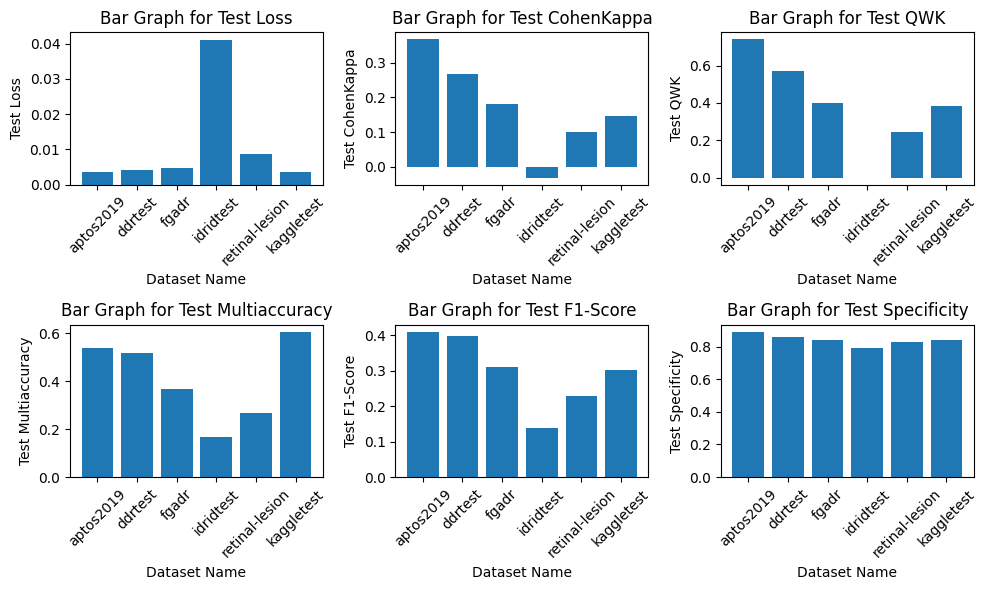

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 391ms | Tot: 13s938ms | tes 8/8  

aptos2019Test set: Average loss: 0.0038, Accuracy: 898/3662 (24.52%), Cohen's Kappa: 0.1184, QWK Score: 0.6539, F1-Score: 0.2627, Specificity: 0.8282
----------------------------------------Test--------

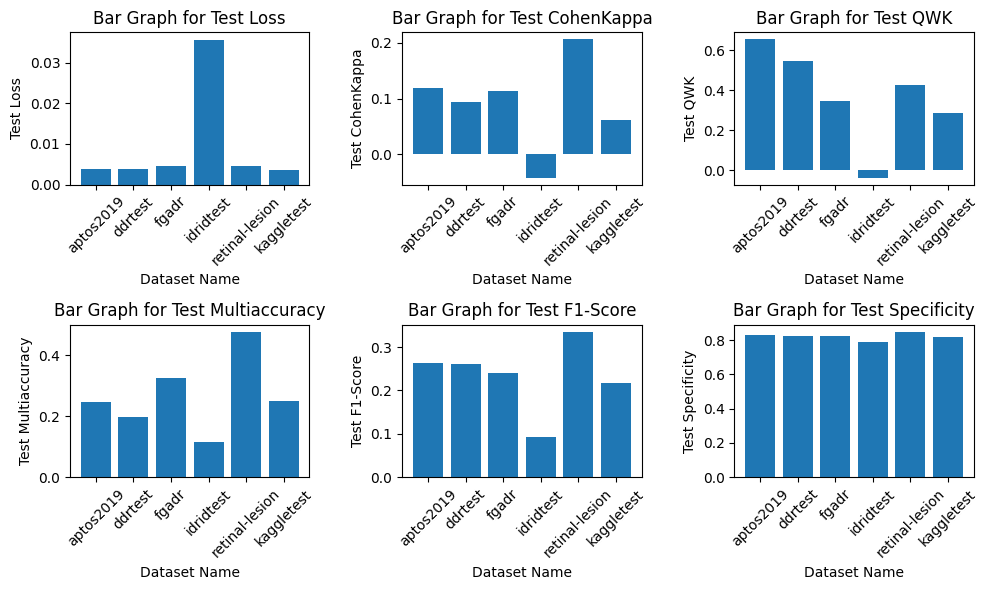

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 391ms | Tot: 14s63ms | test 8/8  

aptos2019Test set: Average loss: 0.0039, Accuracy: 938/3662 (25.61%), Cohen's Kappa: 0.1183, QWK Score: 0.6430, F1-Score: 0.2314, Specificity: 0.8306
----------------------------------------Test--------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 382ms | Tot: 13s419ms | tes 8/8  

aptos2019Test set: Average loss: 0.0032, Accuracy: 1873/3662 (51.15%), Cohen's Kappa: 0.3401, QWK Score: 0.7991, F1-Score: 0.3441, Specificity: 0.8875
----------------------------------------Test-------

In [3]:
effv2path=[r".\Effv2m\Effv2m_ranger21_300circlecrop_augmix",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_fencemask",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_gridmask",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_normalaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_randaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_resample_normalaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_resample_randaug",
 r".\Effv2m\Effv2m_ranger21_300circlecrop_trivialaug"]
for x in range(len(effv2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21withEffv2(filename=effv2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)

# Circle crop with HBPASMwEffV2

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 1s297ms | Tot: 10s19ms | te 8/8 

aptos2019Test set: Average loss: 0.0037, Accuracy: 1336/3662 (36.48%), Cohen's Kappa: 0.1996, QWK Score: 0.6678, F1-Score: 0.2969, Specificity: 0.8492
-----------------

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 275ms | Tot: 11s183ms | tes 8/8  

aptos2019Test set: Average loss: 0.0037, Accuracy: 1516/3662 (41.40%), Cohen's Kappa: 0.2364, QWK Score: 0.6880, F1-Score: 0.2976, Specificity: 0.8606
----------------

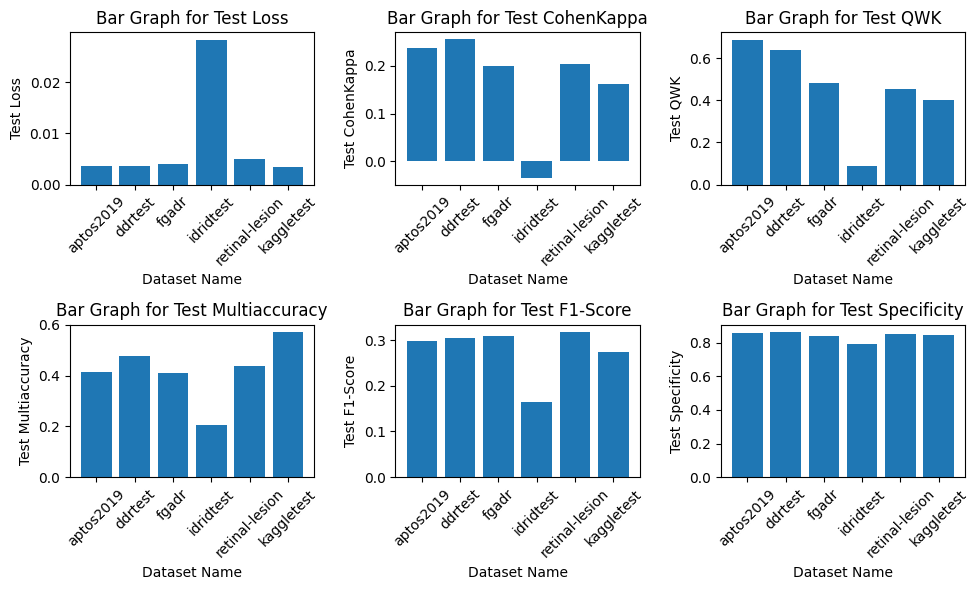

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 297ms | Tot: 9s588ms | test 8/8 

aptos2019Test set: Average loss: 0.0037, Accuracy: 1144/3662 (31.24%), Cohen's Kappa: 0.1388, QWK Score: 0.6366, F1-Score: 0.2276, Specificity: 0.8389
-----------------

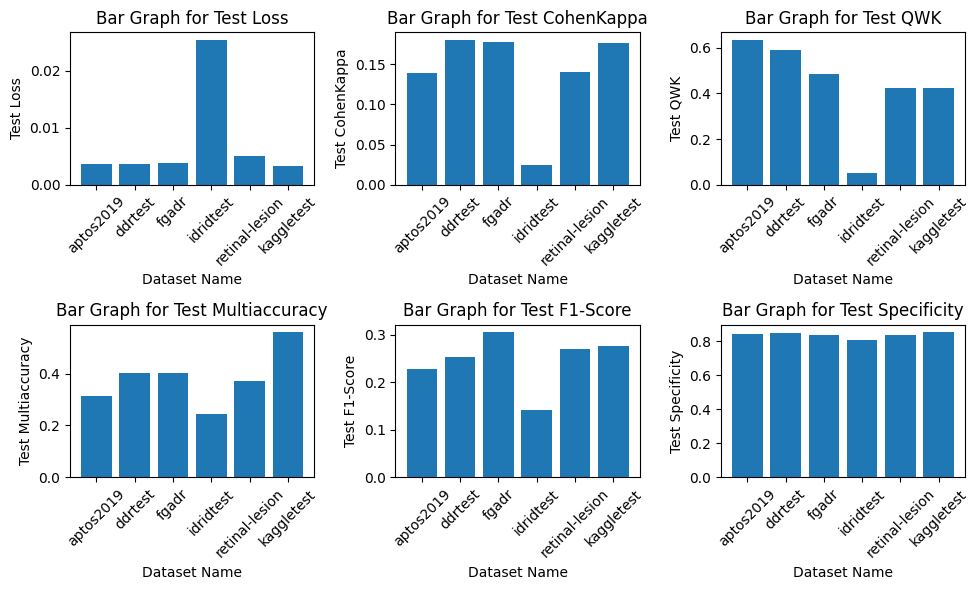

In [3]:
#HBPASMwEffV2
HBPASMwEffV2path=[r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_normalaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_randaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300circlecrop_trivialaug"]
for x in range(len(HBPASMwEffV2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21(filename=HBPASMwEffV2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

# Circle crop with HBPASMDSOD

Model : HBPASM with DSOD
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 2s873ms | Tot: 37s42ms | te 58/58  

aptos2019Test set: Average loss: 0.0255, Accuracy: 1492/3662 (40.74%), Cohen's Kappa: 0.2378, QWK Score: 0.7127, F1-Score: 0.3206, Specificity: 0.8606
------------------------

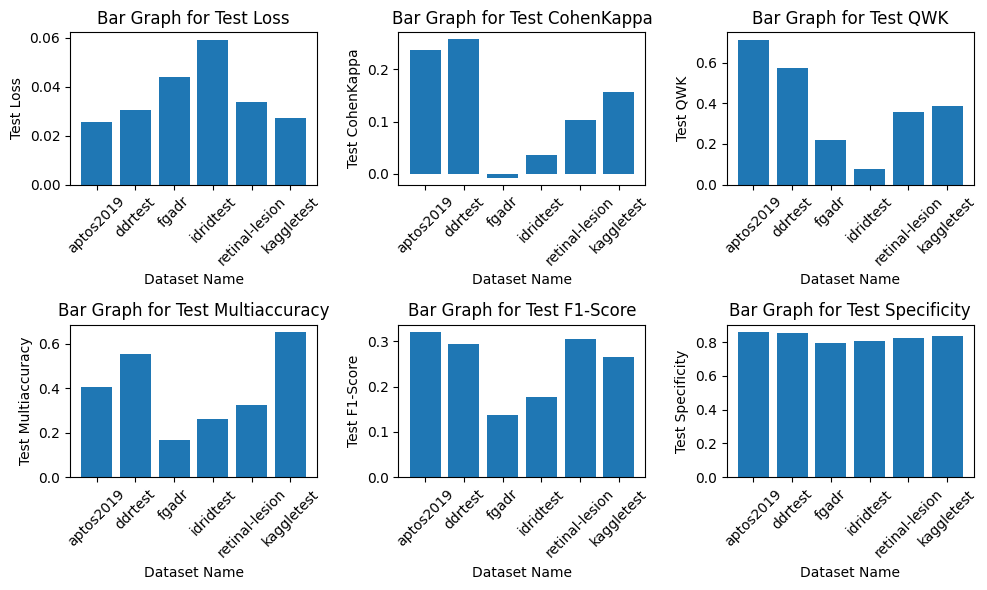

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 106ms | Tot: 25s257ms | tes 58/58 

aptos2019Test set: Average loss: 0.0274, Accuracy: 867/3662 (23.68%), Cohen's Kappa: 0.0956, QWK Score: 0.6082, F1-Score: 0.2223, Specificity: 0.8230
----------------------------------------Test-------

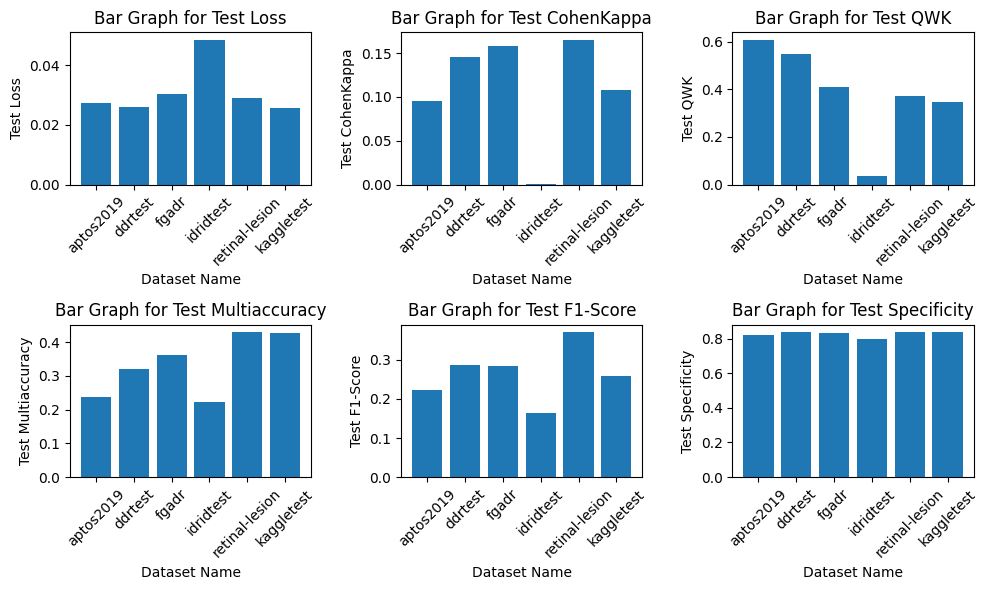

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 107ms | Tot: 25s314ms | tes 58/58 

aptos2019Test set: Average loss: 0.0264, Accuracy: 1258/3662 (34.35%), Cohen's Kappa: 0.1952, QWK Score: 0.7051, F1-Score: 0.2893, Specificity: 0.8550
----------------------------------------Test------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 100ms | Tot: 25s136ms | tes 58/58 

aptos2019Test set: Average loss: 0.0250, Accuracy: 1892/3662 (51.67%), Cohen's Kappa: 0.3403, QWK Score: 0.7860, F1-Score: 0.3069, Specificity: 0.8898
----------------------------------------Test------

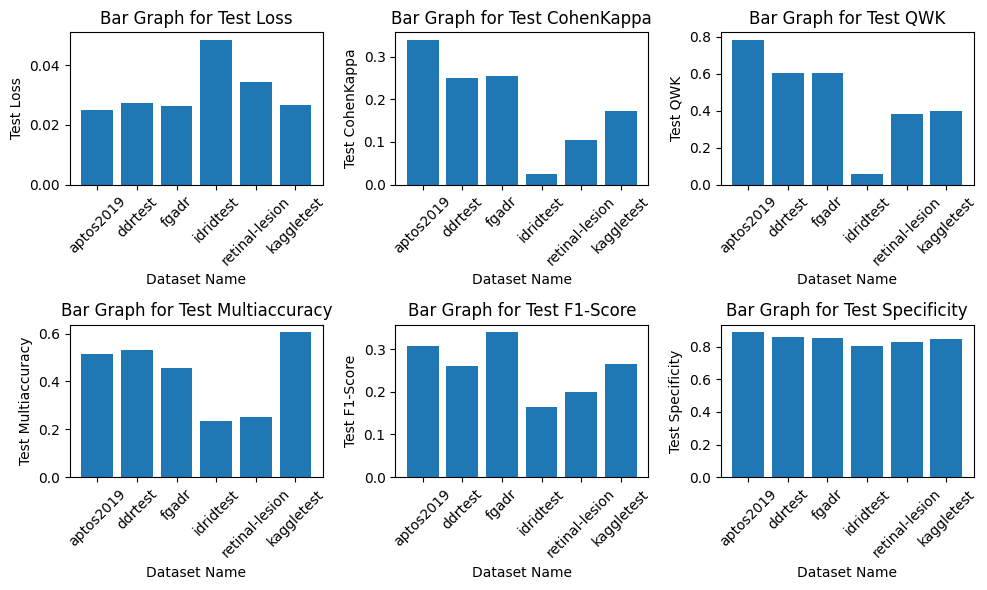

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 110ms | Tot: 25s289ms | tes 58/58 

aptos2019Test set: Average loss: 0.0315, Accuracy: 1291/3662 (35.25%), Cohen's Kappa: 0.0505, QWK Score: 0.1291, F1-Score: 0.1793, Specificity: 0.8122
----------------------------------------Test------

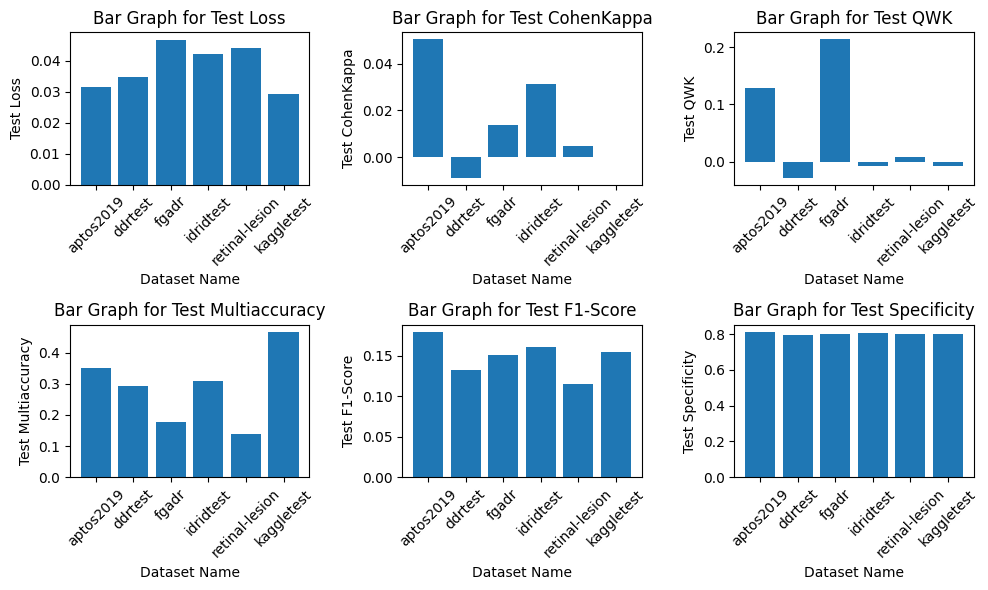

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 106ms | Tot: 25s246ms | tes 58/58 

aptos2019Test set: Average loss: 0.0301, Accuracy: 1498/3662 (40.91%), Cohen's Kappa: 0.2048, QWK Score: 0.4366, F1-Score: 0.2454, Specificity: 0.8506
----------------------------------------Test------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 99ms | Tot: 24s793ms | test 58/58 

aptos2019Test set: Average loss: 0.0265, Accuracy: 1243/3662 (33.94%), Cohen's Kappa: 0.1757, QWK Score: 0.6961, F1-Score: 0.2514, Specificity: 0.8477
----------------------------------------Test------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 101ms | Tot: 24s517ms | tes 58/58 

aptos2019Test set: Average loss: 0.0286, Accuracy: 1127/3662 (30.78%), Cohen's Kappa: 0.1493, QWK Score: 0.6699, F1-Score: 0.2426, Specificity: 0.8416
----------------------------------------Test------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 102ms | Tot: 24s447ms | tes 58/58 

aptos2019Test set: Average loss: 0.0275, Accuracy: 883/3662 (24.11%), Cohen's Kappa: 0.0990, QWK Score: 0.6685, F1-Score: 0.1923, Specificity: 0.8288
----------------------------------------Test-------

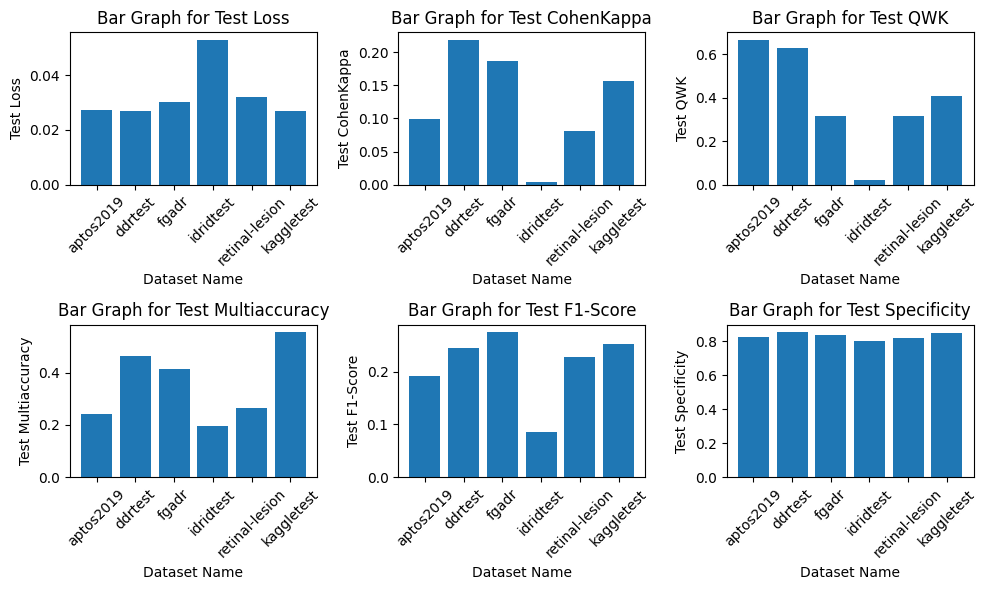

In [4]:
HBPASMwDSOD=[r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_normalaug2",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_resample_normalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecrop_resample_randaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropaugmix",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropfencemask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropgridmask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecropnormalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecroprandaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300circlecroptrivialaug",]
for x in range(len(HBPASMwDSOD)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21(filename=HBPASMwDSOD[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

# 300 image clahe

In [2]:
IMG_SIZE=300
# batch size for effv2 can be 512
batch_size=512
processedimagedir='Ben processed and clahe'
image_dir = os.path.join('..', 'dataset',processedimagedir,'aptos2019')
aptos2019testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
aptos2019testloader = torch.utils.data.DataLoader(aptos2019testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'ddrtest')
ddrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
ddrtestloader = torch.utils.data.DataLoader(ddrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'fgadr')
fgadrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
fgadrtestloader = torch.utils.data.DataLoader(fgadrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'idridtest')
idridtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
idridtesttestloader = torch.utils.data.DataLoader(idridtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'retinallesion')
retinallesiontestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
retinallesiontestloader = torch.utils.data.DataLoader(retinallesiontestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'kaggletest')
kaggletesttestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
kaggletesttestloader = torch.utils.data.DataLoader(kaggletesttestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True

# clahe with Effv2m

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 1s538ms | Tot: 13s765ms | te 8/8 

aptos2019Test set: Average loss: 0.0037, Accuracy: 1278/3662 (34.90%), Cohen's Kappa: 0.1657, QWK Score: 0.6367, F1-Score: 0.2514, Specificity: 0.8443
----------------------------------------Test-------

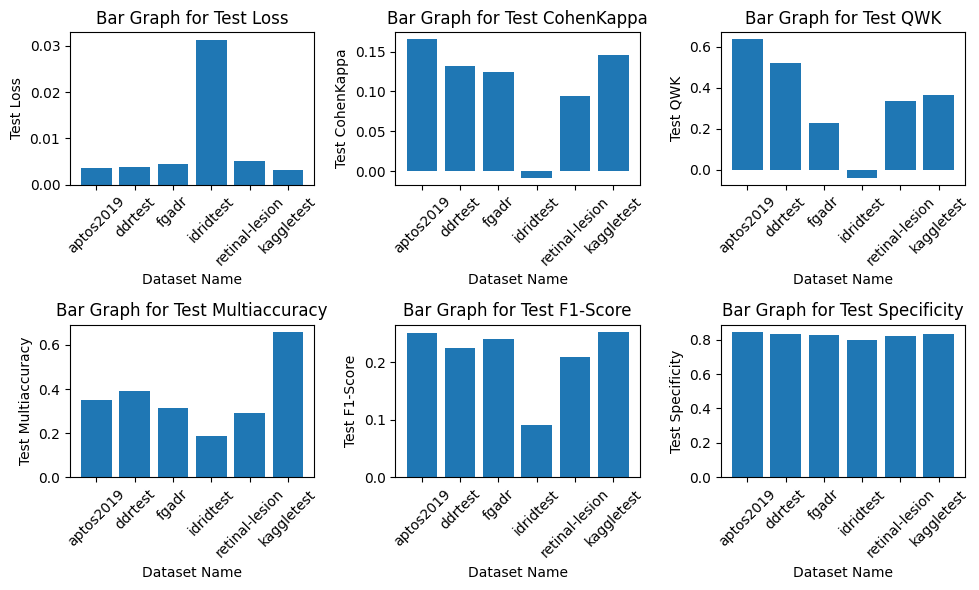

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 453ms | Tot: 35s564ms | tes 8/8  

aptos2019Test set: Average loss: 0.0040, Accuracy: 1041/3662 (28.43%), Cohen's Kappa: 0.1217, QWK Score: 0.6121, F1-Score: 0.2498, Specificity: 0.8325
----------------------------------------Test-------

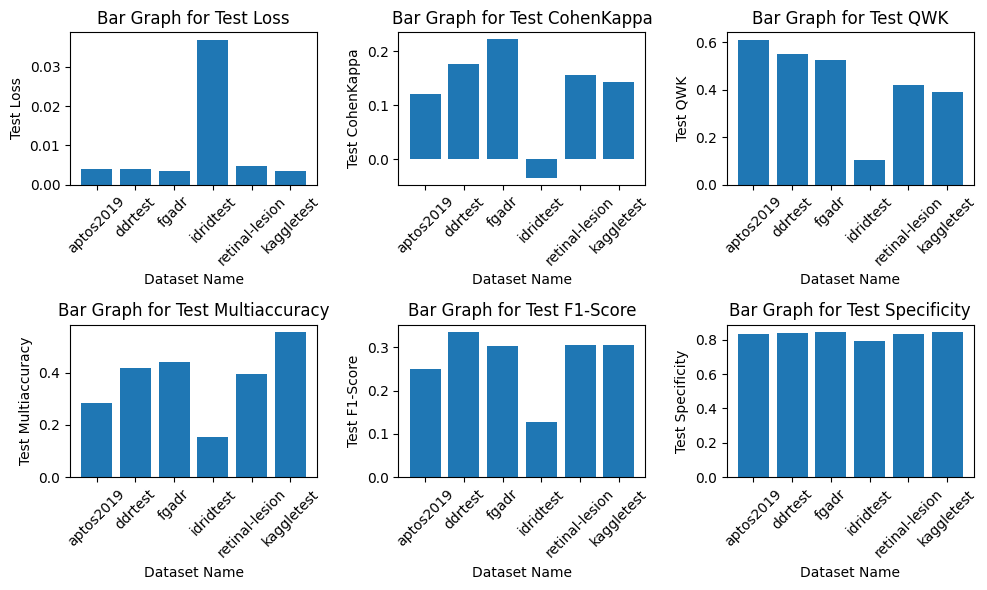

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 370ms | Tot: 38s156ms | tes 8/8 8 

aptos2019Test set: Average loss: 0.0037, Accuracy: 969/3662 (26.46%), Cohen's Kappa: 0.1306, QWK Score: 0.6682, F1-Score: 0.2538, Specificity: 0.8326
----------------------------------------Test-------

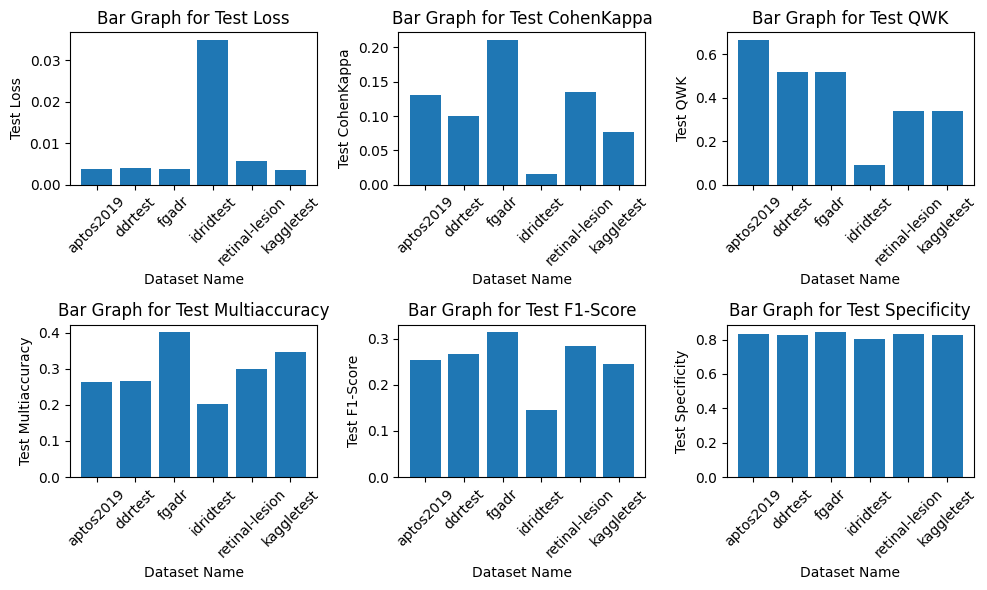

In [3]:
effv2path=[ r".\Effv2m\Effv2m_ranger21_300clahe_normalaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_randaug",
 r".\Effv2m\Effv2m_ranger21_300clahe_trivialaug"]
for x in range(len(effv2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21withEffv2(filename=effv2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 1s530ms | Tot: 14s966ms | te 8/8 

aptos2019Test set: Average loss: 0.0036, Accuracy: 1535/3662 (41.92%), Cohen's Kappa: 0.2491, QWK Score: 0.7219, F1-Score: 0.3258, Specificity: 0.8661
----------------------------------------Test-------

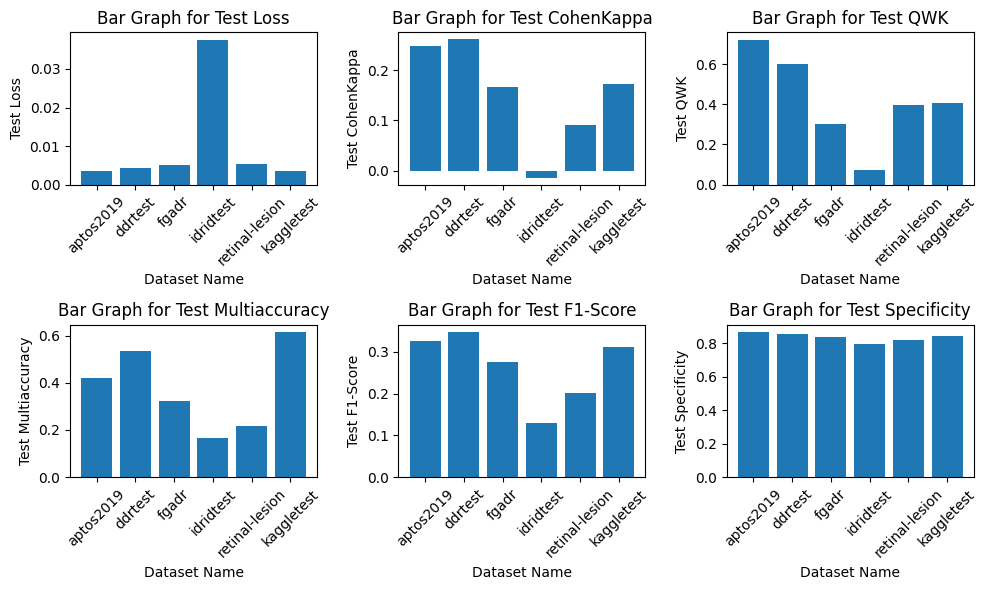

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 427ms | Tot: 14s986ms | tes 8/8  

aptos2019Test set: Average loss: 0.0041, Accuracy: 1152/3662 (31.46%), Cohen's Kappa: 0.1433, QWK Score: 0.4429, F1-Score: 0.2686, Specificity: 0.8361
----------------------------------------Test-------

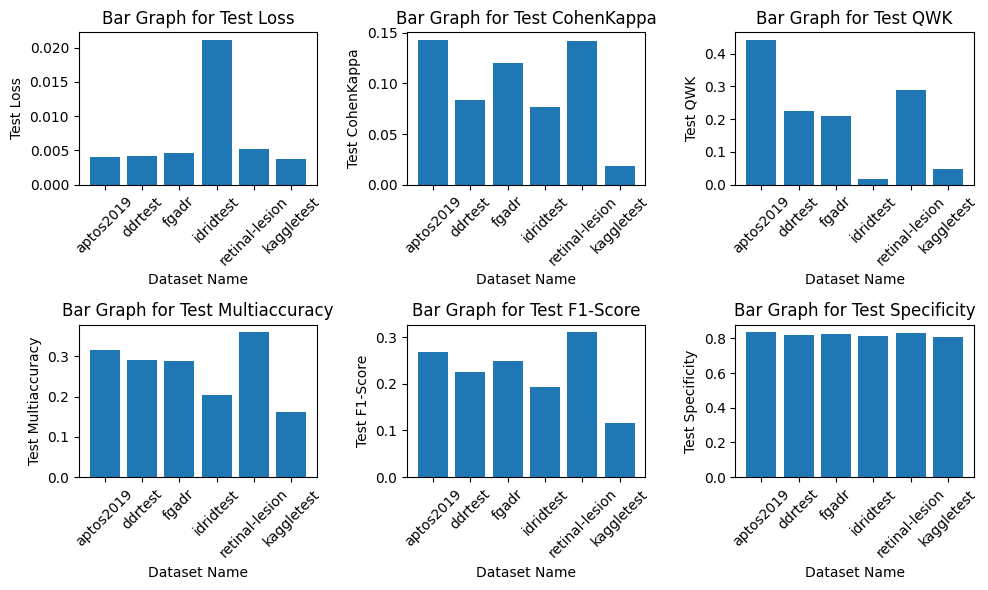

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 375ms | Tot: 38s227ms | tes 8/8  

aptos2019Test set: Average loss: 0.0046, Accuracy: 1780/3662 (48.61%), Cohen's Kappa: 0.2249, QWK Score: 0.4249, F1-Score: 0.3199, Specificity: 0.8487
----------------------------------------Test-------

In [3]:

effv2path=[ r".\Effv2m\Effv2m_ranger21_300clahe_augmix",
 r".\Effv2m\Effv2m_ranger21_300clahe_gridmask",
 r".\Effv2m\Effv2m_ranger21_300clahe_fencemask"]
for x in range(len(effv2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21withEffv2(filename=effv2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

# clahe with HBPASMwEffV2

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 754ms | Tot: 10s53ms | test 8/8 

aptos2019Test set: Average loss: 0.0034, Accuracy: 1538/3662 (42.00%), Cohen's Kappa: 0.2572, QWK Score: 0.7410, F1-Score: 0.3319, Specificity: 0.8665
-----------------

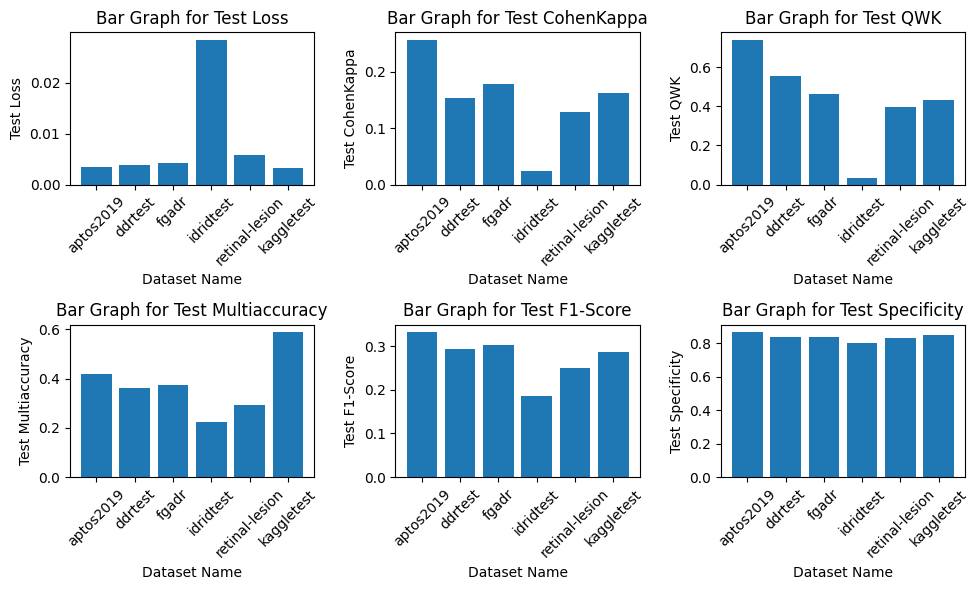

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 268ms | Tot: 9s303ms | test 8/8 

aptos2019Test set: Average loss: 0.0048, Accuracy: 833/3662 (22.75%), Cohen's Kappa: 0.0857, QWK Score: 0.2712, F1-Score: 0.1638, Specificity: 0.8230
------------------

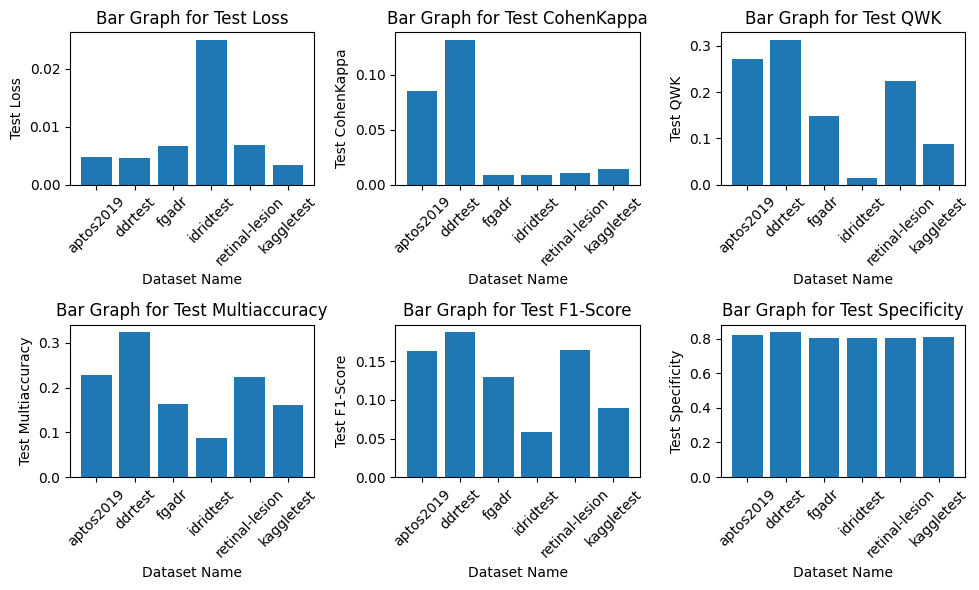

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 263ms | Tot: 9s320ms | test 8/8 

aptos2019Test set: Average loss: 0.0054, Accuracy: 2116/3662 (57.78%), Cohen's Kappa: 0.2822, QWK Score: 0.4352, F1-Score: 0.3114, Specificity: 0.8574
-----------------

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 261ms | Tot: 9s307ms | test 8/8 

aptos2019Test set: Average loss: 0.0039, Accuracy: 1108/3662 (30.26%), Cohen's Kappa: 0.1416, QWK Score: 0.5953, F1-Score: 0.2514, Specificity: 0.8346
-----------------

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 272ms | Tot: 9s297ms | test 8/8 

aptos2019Test set: Average loss: 0.0038, Accuracy: 1251/3662 (34.16%), Cohen's Kappa: 0.1789, QWK Score: 0.6793, F1-Score: 0.2841, Specificity: 0.8471
-----------------

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 271ms | Tot: 9s283ms | test 8/8 

aptos2019Test set: Average loss: 0.0039, Accuracy: 954/3662 (26.05%), Cohen's Kappa: 0.0970, QWK Score: 0.5827, F1-Score: 0.2048, Specificity: 0.8261
------------------

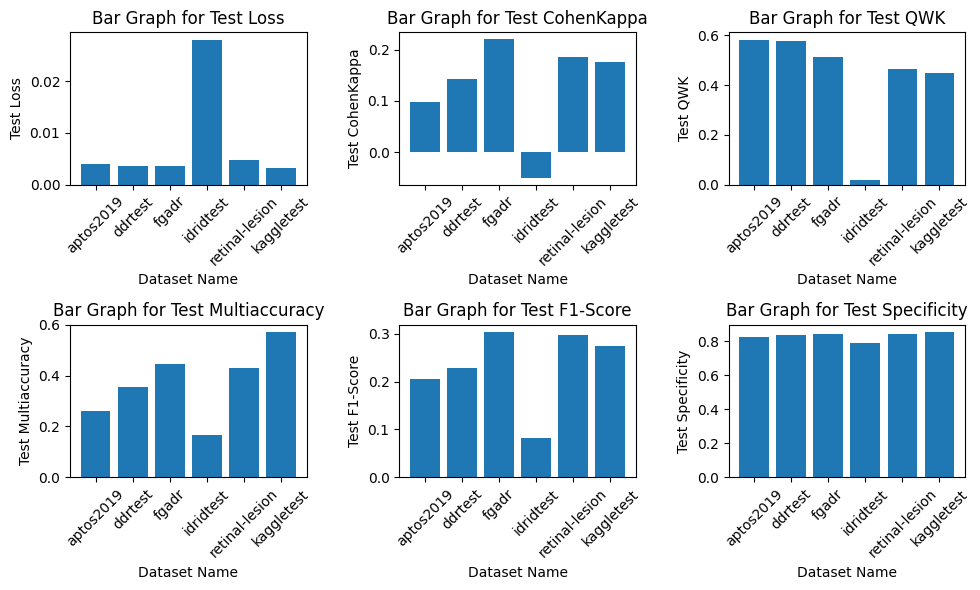

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 273ms | Tot: 9s353ms | test 8/8 

aptos2019Test set: Average loss: 0.0037, Accuracy: 1564/3662 (42.71%), Cohen's Kappa: 0.2462, QWK Score: 0.6667, F1-Score: 0.3060, Specificity: 0.8621
-----------------

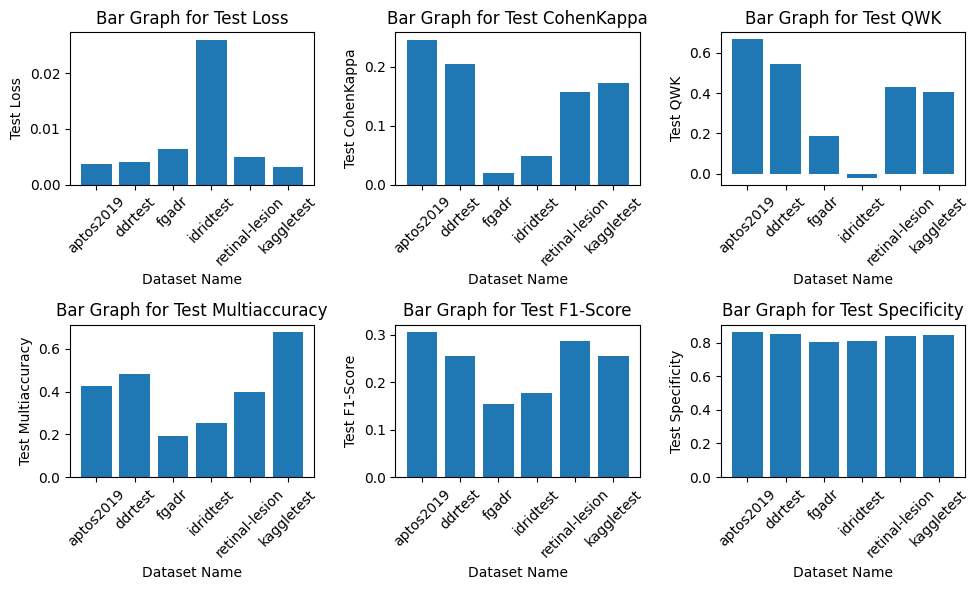

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 276ms | Tot: 9s342ms | test 8/8 

aptos2019Test set: Average loss: 0.0042, Accuracy: 919/3662 (25.10%), Cohen's Kappa: 0.0915, QWK Score: 0.5895, F1-Score: 0.2179, Specificity: 0.8241
------------------

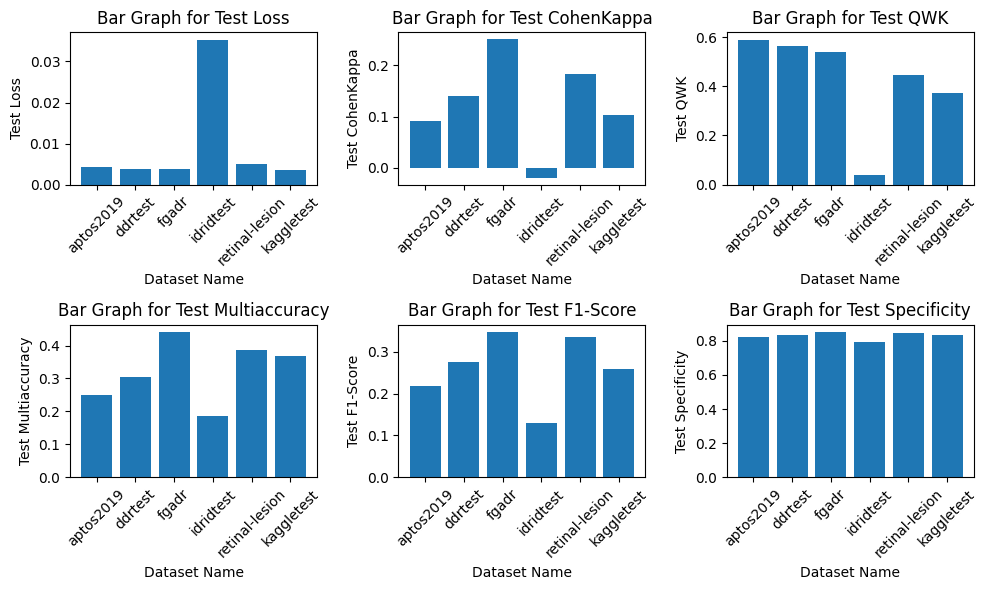

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 269ms | Tot: 9s281ms | test 8/8 

aptos2019Test set: Average loss: 0.0036, Accuracy: 1311/3662 (35.80%), Cohen's Kappa: 0.1877, QWK Score: 0.6783, F1-Score: 0.2806, Specificity: 0.8487
-----------------

In [4]:
effv2path=[r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_augmix2",
 r".\HBPASMwithEffv2\HBPASMwEffv2_ranger21_300clahe_fencemask2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_gridmask2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_normalaug2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_randaug2",
 r".\HBPASMwithEffv2\HBPASMwEFFv2_ranger21_300clahe_trivialaug2",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_normalaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_randaug",
 r".\HBPASMwithEffv2\HBPASMwithEffv2_ranger21_300clahe_trivialaug"]
for x in range(len(effv2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21(filename=effv2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

# clahe HBPASM DSOD

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 1s608ms | Tot: 25s230ms | te 58/58 

aptos2019Test set: Average loss: 0.0248, Accuracy: 1952/3662 (53.30%), Cohen's Kappa: 0.3524, QWK Score: 0.7442, F1-Score: 0.3447, Specificity: 0.8877
----------------------------------------Test-----

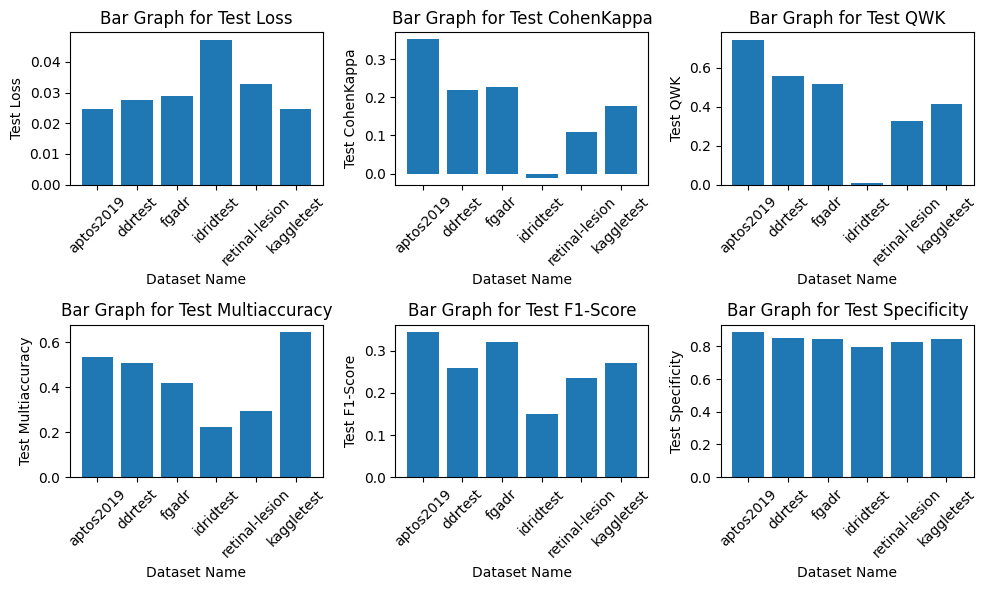

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 98ms | Tot: 56s803ms | test 58/58  

aptos2019Test set: Average loss: 0.0307, Accuracy: 1696/3662 (46.31%), Cohen's Kappa: 0.1442, QWK Score: 0.2546, F1-Score: 0.2387, Specificity: 0.8314
----------------------------------------Test-----

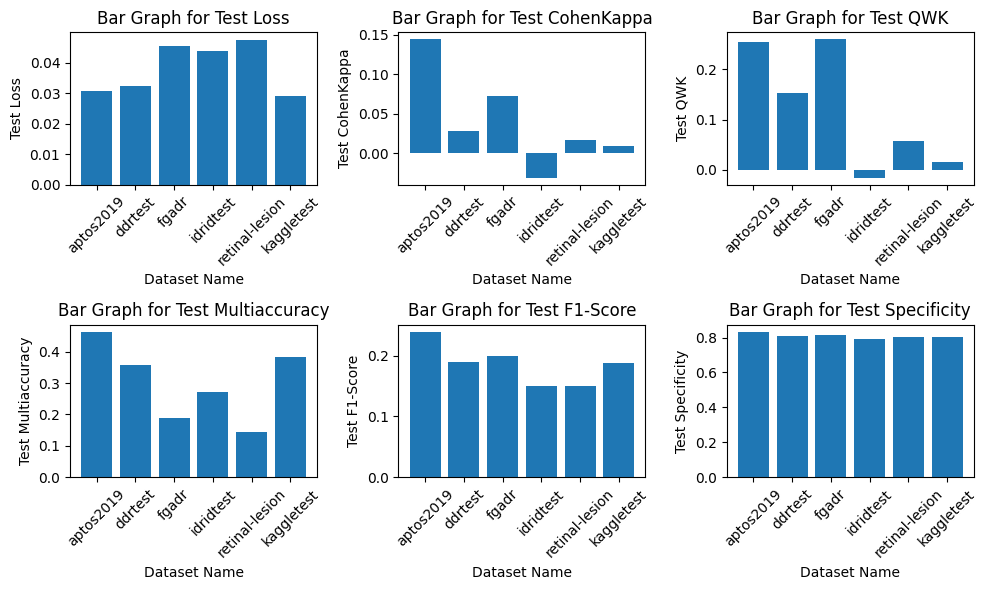

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 101ms | Tot: 25s377ms | tes 58/58 

aptos2019Test set: Average loss: 0.0325, Accuracy: 819/3662 (22.36%), Cohen's Kappa: 0.0601, QWK Score: 0.0994, F1-Score: 0.1316, Specificity: 0.8167
----------------------------------------Test-------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 101ms | Tot: 24s244ms | tes 58/58 

aptos2019Test set: Average loss: 0.0278, Accuracy: 1000/3662 (27.31%), Cohen's Kappa: 0.1183, QWK Score: 0.6199, F1-Score: 0.2184, Specificity: 0.8314
----------------------------------------Test------

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 101ms | Tot: 25s24ms | test 58/58 

aptos2019Test set: Average loss: 0.0268, Accuracy: 1454/3662 (39.71%), Cohen's Kappa: 0.2220, QWK Score: 0.6762, F1-Score: 0.2893, Specificity: 0.8568
----------------------------------------Test------

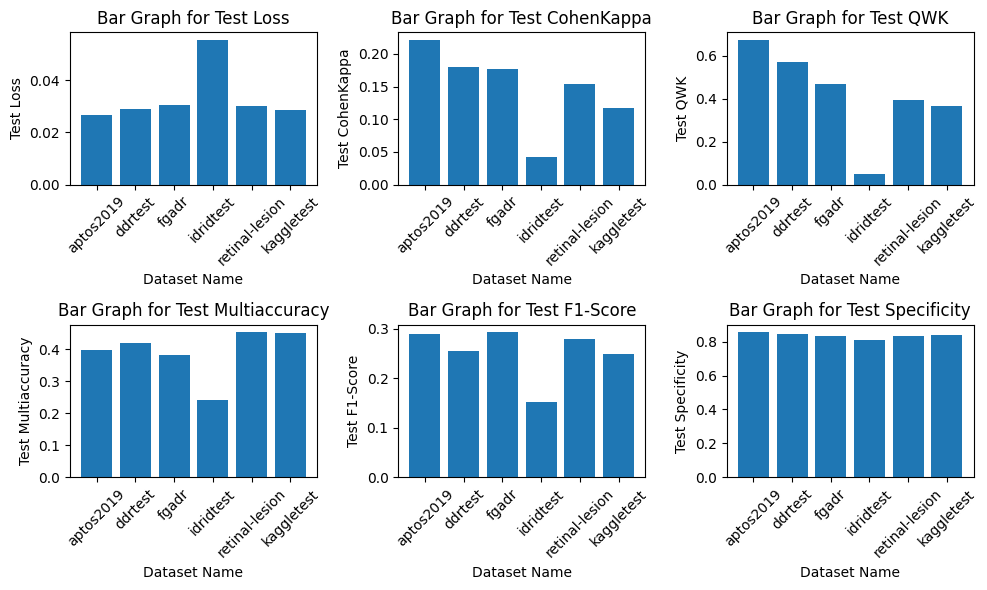

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [=======================================>]  Step: 101ms | Tot: 24s922ms | tes 58/58 

aptos2019Test set: Average loss: 0.0269, Accuracy: 1437/3662 (39.24%), Cohen's Kappa: 0.2112, QWK Score: 0.6418, F1-Score: 0.2872, Specificity: 0.8533
----------------------------------------Test------

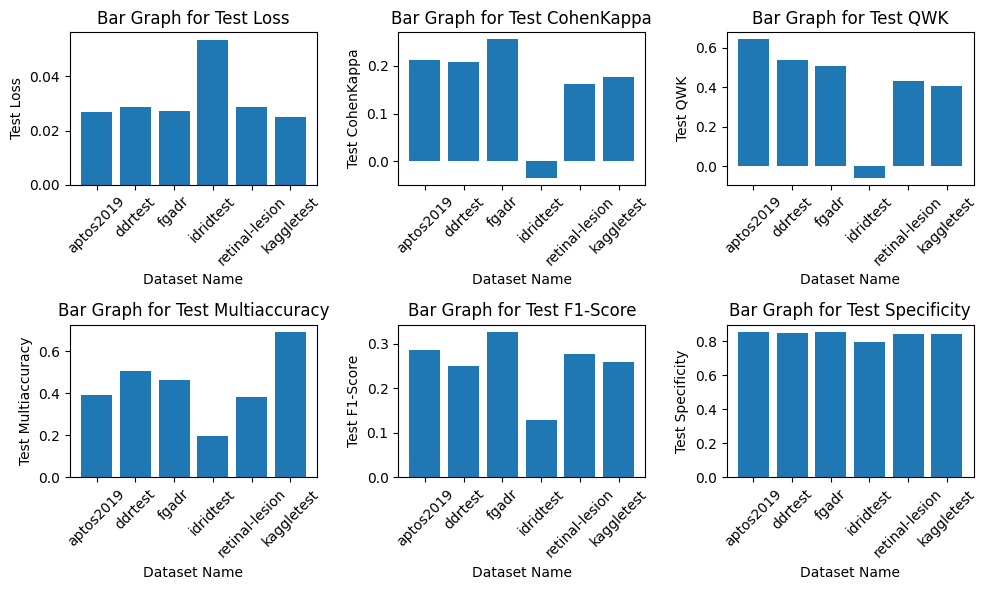

In [3]:
HBPASMwDSOD=[r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_augmix",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_fencemask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_gridmask",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_normalaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_randaug",
 r".\HBPASMDSOD\DSODHBPASM_ranger21_300clahe_trivialaug"]
for x in range(len(HBPASMwDSOD)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21(filename=HBPASMwDSOD[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

# default ben

In [7]:
IMG_SIZE=300
# batch size for effv2 can be 512
batch_size=512
processedimagedir='Ben processed'
image_dir = os.path.join('..', 'dataset',processedimagedir,'aptos2019')
aptos2019testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
aptos2019testloader = torch.utils.data.DataLoader(aptos2019testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'ddrtest')
ddrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
ddrtestloader = torch.utils.data.DataLoader(ddrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'fgadr')
fgadrtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
fgadrtestloader = torch.utils.data.DataLoader(fgadrtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'idridtest')
idridtestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
idridtesttestloader = torch.utils.data.DataLoader(idridtestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset',processedimagedir,'retinallesion')
retinallesiontestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
retinallesiontestloader = torch.utils.data.DataLoader(retinallesiontestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

image_dir = os.path.join('..', 'dataset','kaggle diabetic-retinopathy-detection','processedtestimages_512x512')
kaggletesttestset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
kaggletesttestloader = torch.utils.data.DataLoader(kaggletesttestset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True

# Default Ben Effc2M

In [8]:
effv2path=[
 r".\Effv2m\Effv2m_ranger21_300defaultben_normalaug",
 r".\Effv2m\Effv2m_ranger21_300defaultben_randaug",
 r".\Effv2m\Effv2m_ranger21_300defaultben_trivialaug"]
for x in range(len(effv2path)):
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest'] "E:\FYP\dataset\Effv2m\Effv2m_ranger21_300circlecrop_augmix.csv"
    testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
    model=crossvalidatemodel.ModelRanger21withEffv2(filename=effv2path[x],lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
    #[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
    df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
    plot_multipledataset(df)
    torch.cuda.empty_cache()

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 396ms | Tot: 22s492ms | tes 8/8   

aptos2019Test set: Average loss: 0.0035, Accuracy: 1125/3662 (30.72%), Cohen's Kappa: 0.1638, QWK Score: 0.7241, F1-Score: 0.2805, Specificity: 0.8443
----------------------------------------Test------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 371ms | Tot: 13s339ms | tes 8/8  

aptos2019Test set: Average loss: 0.0036, Accuracy: 1629/3662 (44.48%), Cohen's Kappa: 0.2752, QWK Score: 0.7270, F1-Score: 0.3598, Specificity: 0.8701
----------------------------------------Test-------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 391ms | Tot: 13s239ms | tes 8/8  

aptos2019Test set: Average loss: 0.0034, Accuracy: 1838/3662 (50.19%), Cohen's Kappa: 0.3263, QWK Score: 0.7414, F1-Score: 0.3734, Specificity: 0.8810
----------------------------------------Test-------

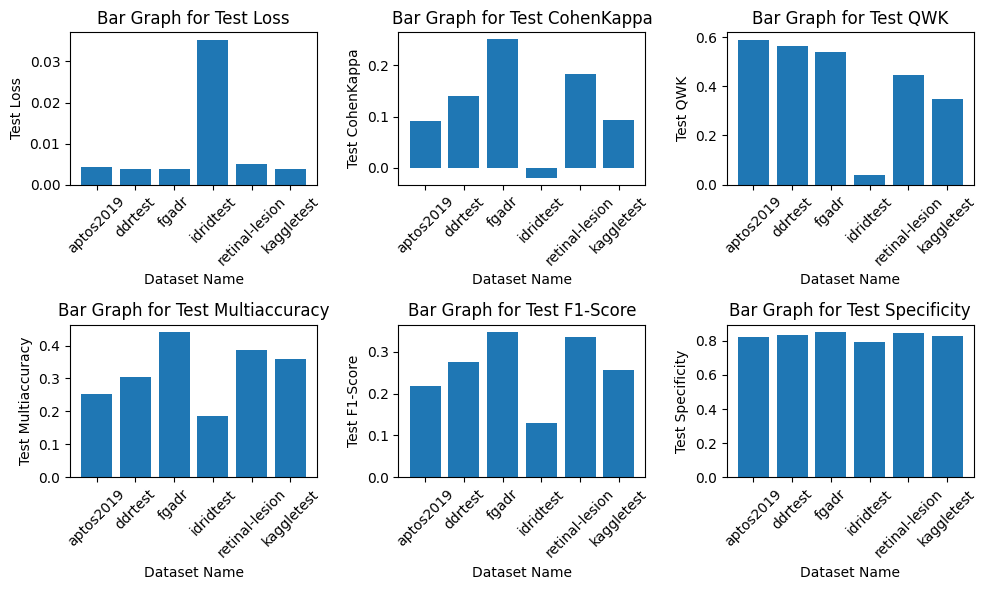

In [6]:
plot_multipledataset(df)

Model : HBPASM with EfficientNetv2
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 1s338ms | Tot: 12s129ms | te 8/8 

aptos2019Test set: Average loss: 0.0036, Accuracy: 1309/3662 (35.75%), Cohen's Kappa: 0.1871, QWK Score: 0.6781, F1-Score: 0.2802, Specificity: 0.8485
----------------

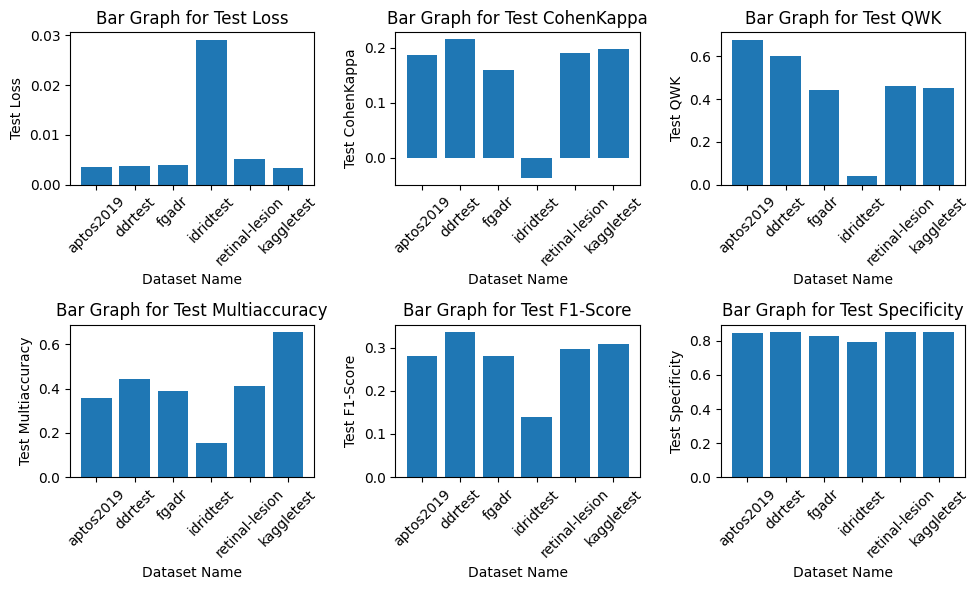

In [3]:
#HBPASMwithEffv2_ranger21_300clahe_trivialaug
testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
model=crossvalidatemodel.ModelRanger21(filename='HBPASMwithEffv2_ranger21_300clahe_trivialaug',lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
#[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])
plot_multipledataset(df)

In [6]:
#testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
testdatasetname=['aptos2019','ddrtest','fgadr','idridtest','retinal-lesion','kaggletest']
model=crossvalidatemodel.ModelRanger21withEffv2(filename='Effv2m_ranger21_300circlecrop_trivialaug',lr=0.001,num_batches_per_epoch=len(aptos2019testset),datasetname=testdatasetname)
#[aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader]
df,target_layers=model.testdataset([aptos2019testloader,ddrtestloader,fgadrtestloader,idridtesttestloader,retinallesiontestloader,kaggletesttestloader])

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 395496 of 549300
warm down will decay until 3e-05 lr
----------------------------------------Test---------------------------------------------
 [===================================>....]  Step: 376ms | Tot: 13s172ms | tes 8/8  

aptos2019Test set: Average loss: 0.0032, Accuracy: 1873/3662 (51.15%), Cohen's Kappa: 0.3400, QWK Score: 0.7988, F1-Score: 0.3441, Specificity: 0.8874
----------------------------------------Test-------

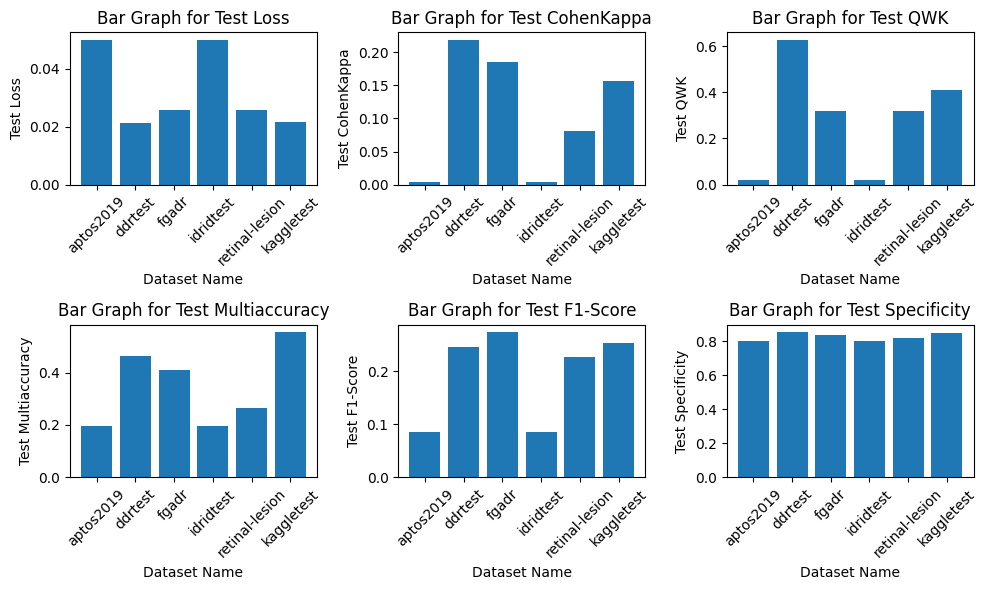

In [13]:
def plot_multipledataset(df):
    metrics = set()
    num_metrics = 6  # Excluding "Train Confusion Matrix" and "Test Confusion Matrix"
    subplot_rows = 2
    subplot_cols = 3

    fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(10, 6))

    subplot_idx = 0 

    for i, column in enumerate(df.columns):
        if column != "Test Confusion Matrix" and column!='Dataset Name':
            row = subplot_idx // subplot_cols
            col = subplot_idx % subplot_cols
            ax = axs[row, col]
            ax.bar(df['Dataset Name'], df[column])
            ax.set_xlabel('Dataset Name')
            ax.set_ylabel(column)
            ax.set_title(f'Bar Graph for {column}')
            ax.tick_params(axis='x', rotation=45)
            ax.tick_params(axis='x', which='both', labelbottom=True)
            ax.tick_params(axis='y', which='both', labelleft=True)
            subplot_idx += 1

    plt.tight_layout()
    plt.show()
plot_multipledataset(df)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_confmat, annot=True, cmap="Blues", fmt="d")
plt.title("Train Confusion Matrix (QWK={:.4f})".format(df.loc[max_qwk_index, "Test QWK"]))
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(test_confmat, annot=True, cmap="Blues", fmt="d")
plt.title("Test Confusion Matrix (QWK={:.4f})".format(df.loc[max_qwk_index, "Test QWK"]))
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()

tensor([0])


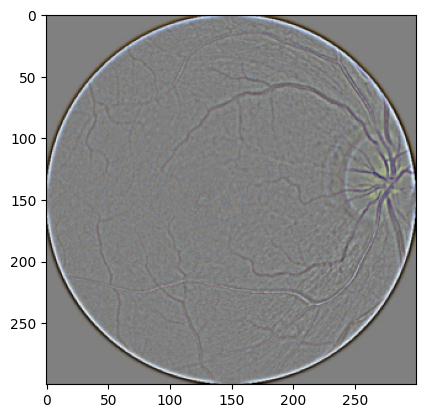

In [4]:
gradcamiddrtestloader = torch.utils.data.DataLoader(ddrtestset, batch_size=1,
                                         shuffle=False, num_workers=4)

images, labels = next(iter(gradcamiddrtestloader))
print(labels)
numpy_array = images[0].numpy()
if numpy_array.max() <= 1.0:
    numpy_array *= 255
# Convert the NumPy array to uint8 data type
uint8_array = numpy_array.astype(np.uint8)

# Reorder the dimensions if necessary
rgb_array = uint8_array.transpose((1, 2, 0))
plt.imshow(rgb_array)

In [5]:
for param in model.model.parameters():
    param.requires_grad = True
cam = GradCAM(model=model.model, target_layers=target_layers, use_cuda=True)
images, labels = next(iter(gradcamiddrtestloader))
targets = [ClassifierOutputSoftmaxTarget(4)]
grayscale_cam = cam(input_tensor=images)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_array.astype(np.float32) / 255.0, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

output layer torch.Size([1, 24576])


In [27]:
import cv2
image = cv2.imread(r"E:\FYP\dataset\ben processed circle crop\ddrtest\4\007-6962-400.jpeg.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = transforms.ToTensor()
tensor_image = transform(image)
tensor_image = tensor_image.unsqueeze(0)

In [28]:
numpy_array = tensor_image[0].numpy()
if numpy_array.max() <= 1.0:
    numpy_array *= 255
# Convert the NumPy array to uint8 data type
uint8_array = numpy_array.astype(np.uint8)

# Reorder the dimensions if necessary
rgb_array = uint8_array.transpose((1, 2, 0))

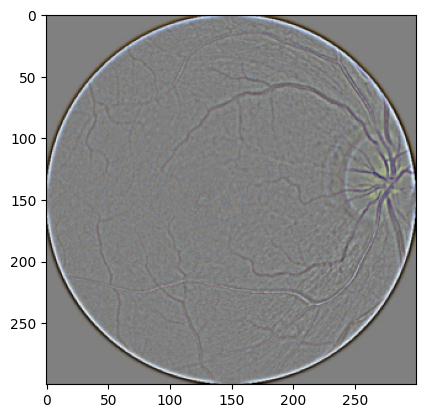

In [10]:
numpy_array = images[0].numpy()
if numpy_array.max() <= 1.0:
    numpy_array *= 255
# Convert the NumPy array to uint8 data type
uint8_array = numpy_array.astype(np.uint8)

# Reorder the dimensions if necessary
rgb_array = uint8_array.transpose((1, 2, 0))
plt.imshow(rgb_array)

In [29]:
for param in model.model.parameters():
    param.requires_grad = True
cam = GradCAM(model=model.model, target_layers=target_layers, use_cuda=True)
images, labels = next(iter(gradcamiddrtestloader))
targets = [ClassifierOutputSoftmaxTarget(4)]
grayscale_cam = cam(input_tensor=tensor_image)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_array.astype(np.float32) / 255.0, grayscale_cam, use_rgb=True)
plt.imshow(visualization)